In [ ]:
#  Import Required Libraries
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import keras
import scipy
import sklearn
import os
from scipy.signal import butter, filtfilt
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report



In [ ]:
#  Load EEG Data
data_folder = r"D:\dataset eeg"

# Get all .npz files in the folder
npz_files = [f for f in os.listdir(data_folder) if f.endswith('.npz')]

# Load all .npz files into a dictionary
eeg_data = {}
for file in npz_files:
    file_path = os.path.join(data_folder, file)
    data = np.load(file_path, allow_pickle=True)
    eeg_data[file] = data

# Print keys of the first file
first_file = npz_files[0]
print(f"Keys in {first_file}: {list(eeg_data[first_file].keys())}")


Keys in eeg-predictive_train.npz: ['train_signals', 'train_labels']


In [ ]:
#  Merge Training Data
train_signals_1 = eeg_data["eeg-predictive_train.npz"]["train_signals"]
train_labels_1 = eeg_data["eeg-predictive_train.npz"]["train_labels"]

train_signals_2 = eeg_data["eeg-seizure_train.npz"]["train_signals"]
train_labels_2 = eeg_data["eeg-seizure_train.npz"]["train_labels"]

# Merge the datasets
train_signals = np.concatenate((train_signals_1, train_signals_2), axis=0)
train_labels = np.concatenate((train_labels_1, train_labels_2), axis=0)

# Print shape of merged data
print("Merged Train Signals Shape:", train_signals.shape)
print("Merged Train Labels Shape:", train_labels.shape)


Merged Train Signals Shape: (45948, 23, 256)
Merged Train Labels Shape: (45948,)


In [4]:
# Find indices of seizure (1) and non-seizure (0) samples
seizure_indices = np.where(train_labels == 1)[0]
non_seizure_indices = np.where(train_labels == 0)[0]

# Randomly select 5,000 samples from each class
np.random.seed(42)  # For reproducibility
seizure_sample = np.random.choice(seizure_indices, 8000, replace=False)
non_seizure_sample = np.random.choice(non_seizure_indices, 8000, replace=False)

# Combine selected samples
selected_indices = np.concatenate((seizure_sample, non_seizure_sample))

# Subset the dataset
train_signals_balanced = train_signals[selected_indices]
train_labels_balanced = train_labels[selected_indices]

# Print new dataset size
print("Balanced Train Signals Shape:", train_signals_balanced.shape)
print("Balanced Train Labels Shape:", train_labels_balanced.shape)

# Check label distribution
unique, counts = np.unique(train_labels_balanced, return_counts=True)
print("New Label Distribution:", dict(zip(unique, counts)))

Balanced Train Signals Shape: (16000, 23, 256)
Balanced Train Labels Shape: (16000,)
New Label Distribution: {0.0: 8000, 1.0: 8000}


In [ ]:
import numpy as np
import scipy.fftpack

# mav
mav = np.mean(np.abs(train_signals_balanced), axis=(1, 2))

# FFT to get frequency-domain features
fft_features = np.abs(scipy.fftpack.fft(train_signals_balanced, axis=-1))

# Extract low-frequency power 
low_freq_power = np.sum(fft_features[:, :, :15], axis=(1, 2))

# Step 3: Define thresholds
mav_severe_thresh = np.percentile(mav, 90)    # Top 10% MAV → Severe
mav_mild_thresh = np.percentile(mav, 50)      # 50–90% MAV → Mild

low_freq_high_thresh = np.percentile(low_freq_power, 80)  # High seizure pattern

# Step 4: Create new labels using hybrid logic
new_labels = []
for i in range(len(mav)):
    if mav[i] >= mav_severe_thresh or low_freq_power[i] >= low_freq_high_thresh:
        new_labels.append(1)  # Severe Epileptic
    elif mav[i] >= mav_mild_thresh:
        new_labels.append(2)  # Mild Epileptic
    else:
        new_labels.append(0)  # Non-Epileptic

train_labels_balanced = np.array(new_labels)

# Step 5: Print updated label distribution
unique, counts = np.unique(train_labels_balanced, return_counts=True)
print("Label Distribution:", dict(zip(unique, counts)))


Label Distribution: {0: 8000, 1: 3319, 2: 4681}


In [6]:
# Normalize EEG signals (Min-Max Scaling)
train_signals_balanced = (train_signals_balanced - np.min(train_signals_balanced)) / (np.max(train_signals_balanced) - np.min(train_signals_balanced))

print("EEG Signals After Normalization:")
print("Min:", np.min(train_signals_balanced), "Max:", np.max(train_signals_balanced))

EEG Signals After Normalization:
Min: 0.0 Max: 1.0


In [7]:
# Bandpass filter function (removes noise outside 0.5–40 Hz)
def bandpass_filter(data, lowcut=0.5, highcut=40.0, fs=256, order=5):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, data, axis=-1)

# Apply bandpass filter to EEG signals
train_signals_filtered = bandpass_filter(train_signals_balanced)

print("EEG Signals After Bandpass Filtering:")
print("Shape:", train_signals_filtered.shape)

EEG Signals After Bandpass Filtering:
Shape: (16000, 23, 256)


In [8]:
from tensorflow.keras.utils import to_categorical

# Convert labels to categorical (one-hot encoding)
train_labels_onehot = to_categorical(train_labels_balanced, num_classes=3)

# Print first 5 samples to check encoding
print("Example of One-Hot Encoded Labels:")
print(train_labels_onehot[:5])

Example of One-Hot Encoded Labels:
[[0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]]


In [11]:
# 4 fe-lstm mt-lstm+autoencoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input,LSTM,Dropout,Dense
def extract_lstm_features(data, n_features=64):
    model = Sequential([
        Input(shape=(data.shape[1], data.shape[2])),
        LSTM(n_features, return_sequences=False),
        Dropout(0.2),
        Dense(n_features, activation='relu')
    ])
    features = model.predict(data)
    return features, model

n_features = 64
train_features, feature_extractor = extract_lstm_features(train_signals_filtered, n_features)
print("Extracted Features Shape:", train_features.shape)



500/500 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
Extracted Features Shape: (16000, 64)


In [14]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dropout, Dense, RepeatVector, TimeDistributed
from sklearn.model_selection import train_test_split


def create_hybrid_model(input_shape, n_classes=3):
    # Encoder
    inputs = Input(shape=input_shape)
    x = LSTM(128, return_sequences=True)(inputs)
    x = Dropout(0.3)(x)
    x = LSTM(64)(x)
    encoded = Dropout(0.2)(x)

    latent = Dense(32, activation='relu')(encoded)

    # Classification Branch
    class_output = Dense(n_classes, activation='softmax', name='classification')(latent)

    # Decoder Branch
    x = Dense(64)(latent)
    x = RepeatVector(input_shape[0])(x)
    x = LSTM(64, return_sequences=True)(x)
    x = Dropout(0.3)(x)
    x = LSTM(128, return_sequences=True)(x)
    decoded = TimeDistributed(Dense(input_shape[1]), name='time_distributed')(x)

    # Define Hybrid Model
    model = Model(inputs=inputs, outputs=[decoded, class_output])

    # Compile Model
    model.compile(optimizer='adam',
                  loss={'classification': 'categorical_crossentropy', 'time_distributed': 'mse'},
                  loss_weights={'classification': 1.0, 'time_distributed': 0.5},
                  metrics={'classification': 'accuracy'})

    return model

X = train_signals_filtered
y = train_labels_onehot


X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Create Model
model = create_hybrid_model(input_shape=(X.shape[1], X.shape[2]))

# Training Parameters
batch_size = 128
epochs = 20

# Early Stopping
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_classification_accuracy',
    patience=5,
    mode='max',
    restore_best_weights=True
)

# Train the Model
history = model.fit(
    X_train,
    {'classification': y_train, 'time_distributed': X_train},
    validation_data=(X_val, {'classification': y_val, 'time_distributed': X_val}),
    epochs=epochs,
    batch_size=batch_size,
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 18s 117ms/step - classification_accuracy: 0.5583 - classification_loss: 0.9506 - loss: 0.9508 - time_distributed_loss: 3.8798e-04 - val_classification_accuracy: 0.7728 - val_classification_loss: 0.5249 - val_loss: 0.5251 - val_time_distributed_loss: 3.2569e-04
Epoch 2/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 115ms/step - classification_accuracy: 0.7773 - classification_loss: 0.5092 - loss: 0.5094 - time_distributed_loss: 3.2154e-04 - val_classification_accuracy: 0.8334 - val_classification_loss: 0.3867 - val_loss: 0.3869 - val_time_distributed_loss: 3.2225e-04
Epoch 3/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 11s 111ms/step - classification_accuracy: 0.8375 - classification_loss: 0.3872 - loss: 0.3874 - time_distributed_loss: 3.1189e-04 - val_classification_accuracy: 0.8600 - val_classification_loss: 0.3373 - val_loss: 0.3375 - val_time_distributed_loss: 3.2225e-04
Epoch 4/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 11s 109ms/step - classification_accuracy: 0.8578 - classi

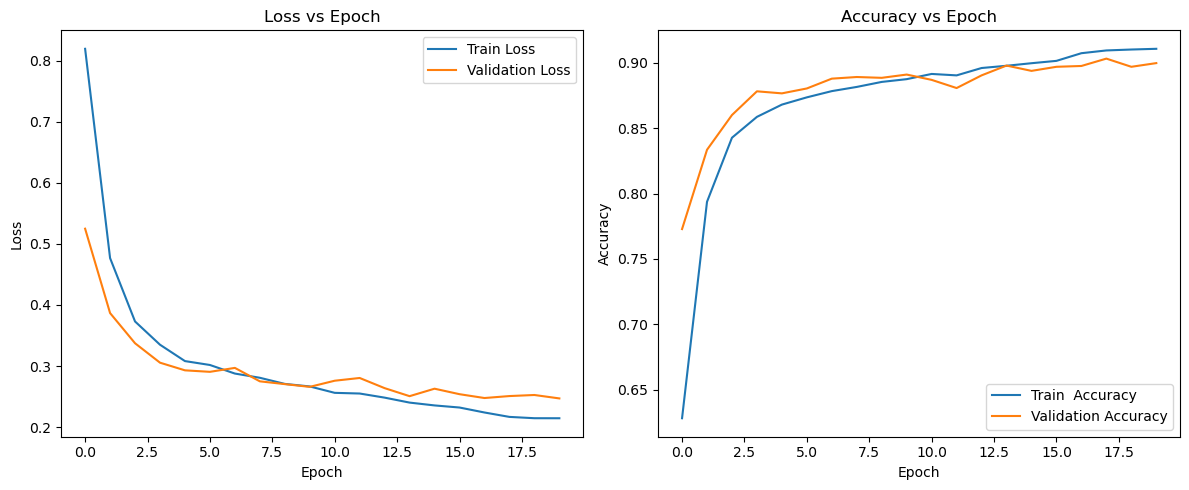

In [16]:
import matplotlib.pyplot as plt

# Plot Loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['classification_loss'], label='Train Loss')
plt.plot(history.history['val_classification_loss'], label='Validation Loss')

plt.title('Loss vs Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['classification_accuracy'], label='Train  Accuracy')
plt.plot(history.history['val_classification_accuracy'], label='Validation Accuracy')
plt.title('Accuracy vs Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step
Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.94      0.94      1600
           1       0.91      0.91      0.91       664
           2       0.84      0.83      0.83       936

    accuracy                           0.90      3200
   macro avg       0.89      0.89      0.89      3200
weighted avg       0.90      0.90      0.90      3200



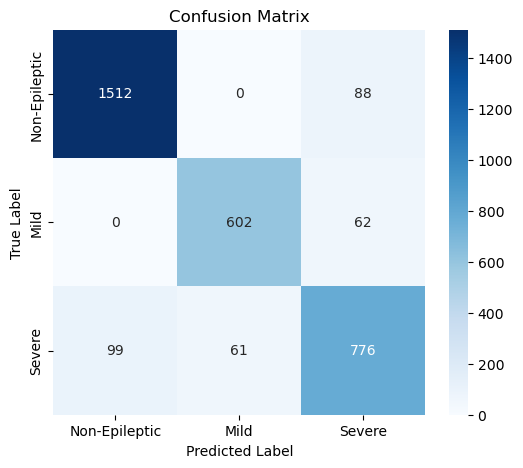

In [17]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


y_pred = model.predict(X_val)[1] 
y_pred_classes = np.argmax(y_pred, axis=1)  
y_true_classes = np.argmax(y_val, axis=1)  


conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)


print("Classification Report:\n", classification_report(y_true_classes, y_pred_classes))

plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Non-Epileptic', 'Mild', 'Severe'], yticklabels=['Non-Epileptic', 'Mild', 'Severe'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step


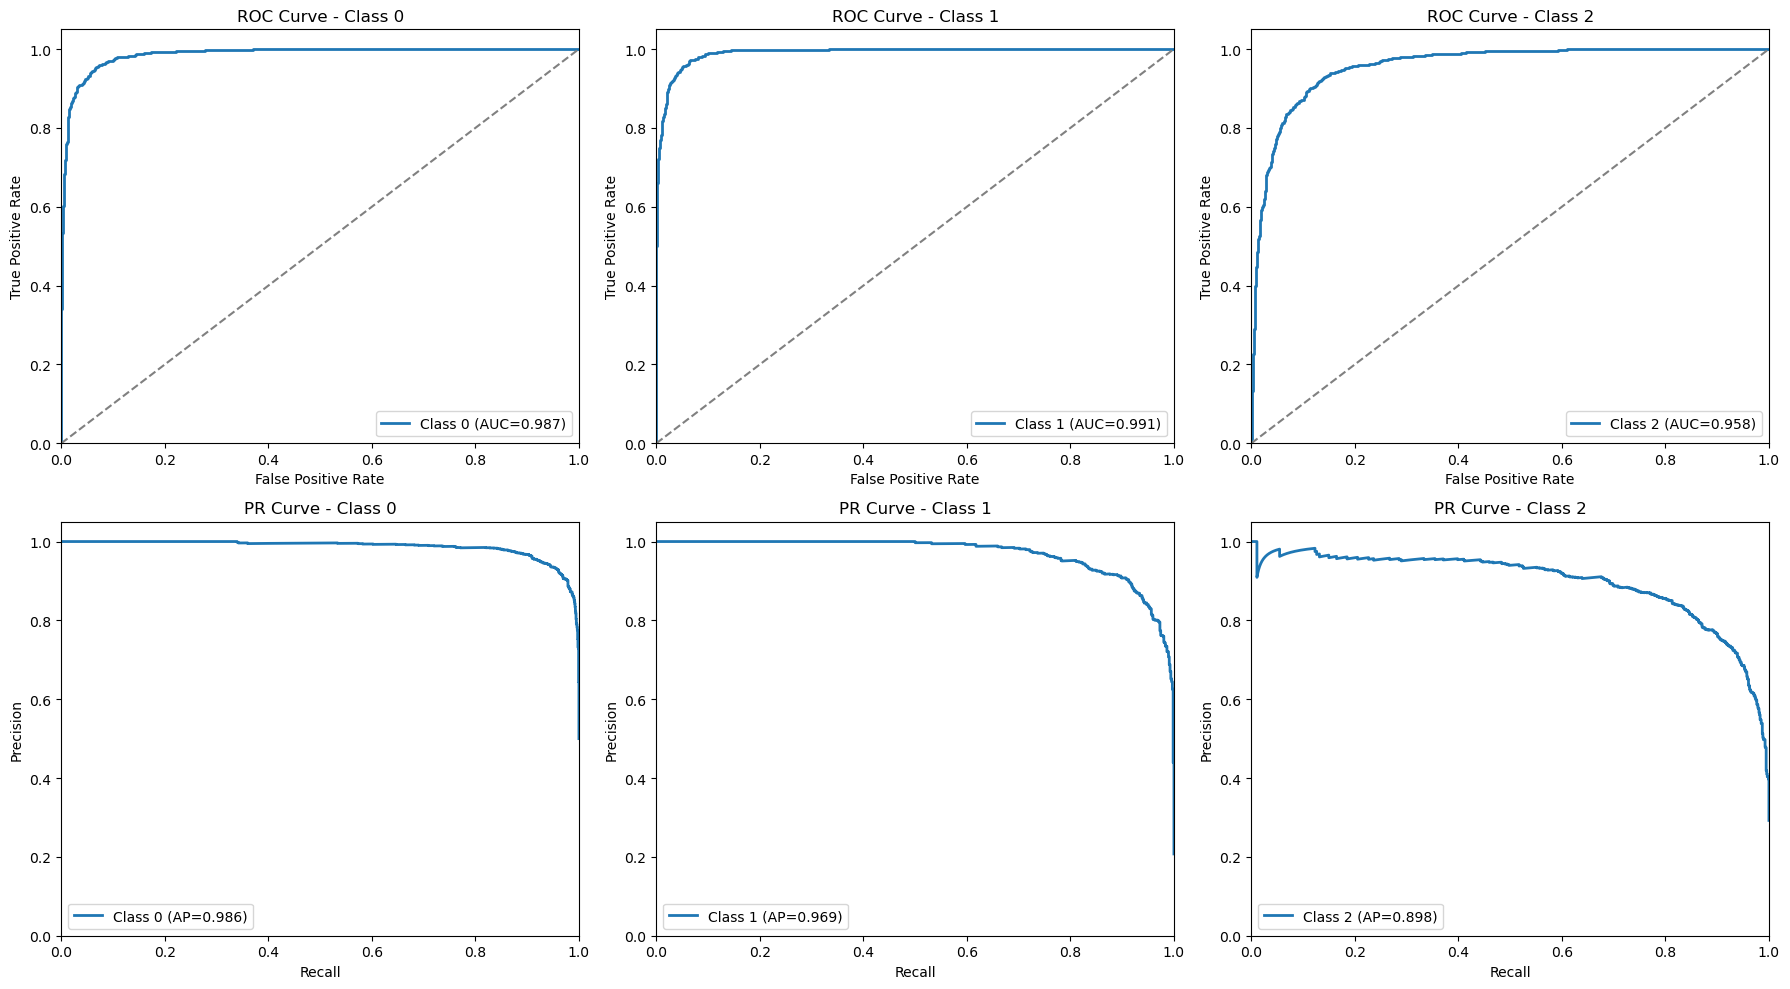

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score

# Define y_true and y_pred_probs
y_true = y_val
_, y_pred_probs = model.predict(X_val)

n_classes = y_true.shape[1]

# Initialize figure with 2 rows: 1st row for ROC, 2nd row for PR curves
fig, axes = plt.subplots(2, n_classes, figsize=(18, 10))

roc_auc_scores = []
ap_scores = []

for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_true[:, i], y_pred_probs[:, i])
    roc_auc = auc(fpr, tpr)
    roc_auc_scores.append(roc_auc)

    precision, recall, _ = precision_recall_curve(y_true[:, i], y_pred_probs[:, i])
    ap = average_precision_score(y_true[:, i], y_pred_probs[:, i])
    ap_scores.append(ap)

    axes[0, i].plot(fpr, tpr, lw=2, label=f'Class {i} (AUC={roc_auc:.3f})')
    axes[0, i].plot([0, 1], [0, 1], color="gray", linestyle="--")
    axes[0, i].set_xlim([0.0, 1.0])
    axes[0, i].set_ylim([0.0, 1.05])
    axes[0, i].set_xlabel('False Positive Rate')
    axes[0, i].set_ylabel('True Positive Rate')
    axes[0, i].set_title(f'ROC Curve - Class {i}')
    axes[0, i].legend(loc="lower right")

    axes[1, i].plot(recall, precision, lw=2, label=f'Class {i} (AP={ap:.3f})')
    axes[1, i].set_xlim([0.0, 1.0])
    axes[1, i].set_ylim([0.0, 1.05])
    axes[1, i].set_xlabel('Recall')
    axes[1, i].set_ylabel('Precision')
    axes[1, i].set_title(f'PR Curve - Class {i}')
    axes[1, i].legend(loc="lower left")

plt.tight_layout()
plt.show()
